In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np

from fastai.vision import *


### Data

In [3]:
path = Path('X-RayImage')

In [4]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Test",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 778, 317)

In [6]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 778
Number of examples in validation: 317


In [7]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

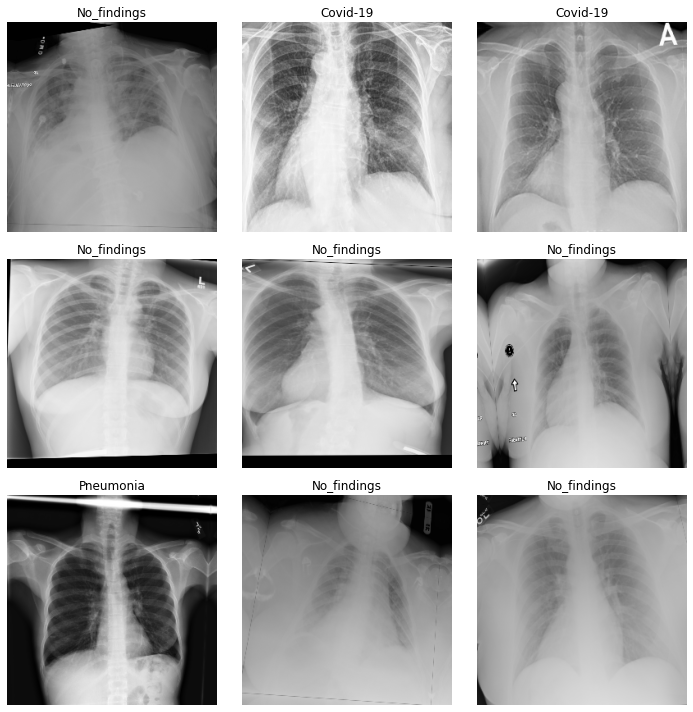

In [8]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [9]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [10]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [11]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [12]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [13]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [14]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [15]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.876145,1.098756,0.444795,01:47
1,0.799832,0.712104,0.716088,01:33
2,0.730014,0.625749,0.750789,01:26
3,0.698285,0.604884,0.744479,01:18
4,0.667660,0.678300,0.703470,01:26
5,0.632754,0.656195,0.722397,01:27
6,0.617741,0.797082,0.662461,01:27
7,0.612985,0.576788,0.772871,01:27
8,0.606980,0.601334,0.735016,01:27
9,0.581716,0.547666,0.766562,01:27


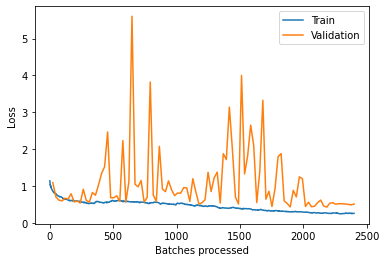

In [16]:
learn.recorder.plot_losses()

In [17]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 317


In [18]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [19]:
accuracy(probs,targets)

tensor(0.8044)

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 778, 317)

In [22]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

317 255 0.804416403785489
[[ 26   4   5]
 [  0 125  16]
 [  0  37 104]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.74      0.85        35
 No_findings       0.75      0.89      0.81       141
   Pneumonia       0.83      0.74      0.78       141

    accuracy                           0.80       317
   macro avg       0.86      0.79      0.82       317
weighted avg       0.82      0.80      0.80       317



In [23]:
interp = ClassificationInterpretation.from_learner(learn)

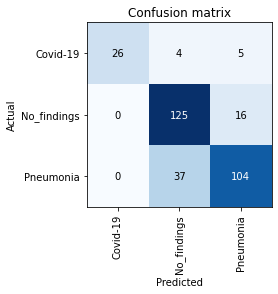

In [24]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);